source file for the documentation in the [jupyter notebook](SystemMatrix.ipynb) and converted to markdown by `jupyter nbconvert`

Extracting System Matrices
=======================

We illustrate the system matrix reading in an example of a acoustic cavity coupled to an elastic plate with a piezo-patch.
Them mesh is generated with the trelis using the [coupled.jou](coupled.jou), which produces the mesh file [coupled.cdb](coupled.cdb).
It is intentionally coarse to better show the structure of the system matrix.
We have an acoustic domain (yellow), plate structure (green), and piezo patch (purple).

![mesh](mesh.png)

The XML input [coupled.xml](coupled.xml) with matrial file [mat.xml](mat.xml) defines a coupled acousric-mechanic-piezoelectric analysis.
The input is targeted at anaysing the system matrix structure, and not intended as a pysical model.

## Defining Matrix Export

Ths system matrix can be easily exported by cfs using
```XML
<linearSystems>
  <system>
    <solutionStrategy>
      <standard>
        <setup idbcHandling="elimination"/>
        <exportLinSys format="matrix-market" system="true" rhs="true" baseName="coupled"/>
      </standard>
    </solutionStrategy> 
  </system>
</linearSystems>
```
in the sequence step.
The result will be written in ASCII files in the working directory, called `baseName_step_<n>_sys_0_0.mtx`, where `<n>` is the frequency or time step.
Depending on the analysis type you can also request the output of mass, stiffness and damping matrix (e.g. for eigenfrequency steps).
The right hand side force vactor is exported in a similarly called file (`*.vec`).
One can read in the matrices with python or matlab.


## Analysing the System Matrix Structure
We use targeted right-hand side load definitions in each PDE to *mark* certain DoFs, siuch that we can recognise them in the exported linear system by analysing the right hand side load vecor.
This is done by using a harmic analysis with 4 frequency steps
```XML
			<harmonic>
				<frequencyList>
 					<freq value="1" />
					<freq value="100" />
					<freq value="200" />
					<freq value="300" />
				</frequencyList>
			</harmonic>
```
Then we define math parser conditionals in the `<bcsAndLoads>` section to switch certain load on for certain frequency steps:

In the acoustic PDE we use a right hand side load density on the complete volume region
```XML
<rhsDensity name="V_air" value="(f lt 50) ? on : ( (f lt 150) ? 0 : 0 )"/>
```
which will be active in step 1 and produce calues in the right hand side load vector of the linear system.
Adittionally we mark the interface DoFs in frequency step 4 by
```XML
<rhsDensity name="S_NC-air" value="(f lt 250) ? 0 : on"/>
```

In the mechanic PDE we use the same techniqe (with `<forceDensity>`) active in step 2
```XML
  <forceDensity name="V_plate">
    <comp dof="x" value="(f lt 50) ? 0 : ( (f lt 150) ? on : 0 )" phase="10" />
	<comp dof="y" value="(f lt 50) ? 0 : ( (f lt 150) ? on : 0 )" phase="20" />
	<comp dof="z" value="(f lt 50) ? 0 : ( (f lt 150) ? on : 0 )" phase="30" />
  </forceDensity>
```
where additionally the *phase* is used to mark x, y and z DoFs.
Note that this must berepeated for all mechanic regions (`V_plate` and `V_piezo`).

All electrostatic DoFs are marked in step 3 using
```XML
  <chargeDensity name="V_piezo" value="(f lt 50) ? 0 : ( (f lt 150) ? 0 : on )" phase="90"/>  
```
for the volume regions and, in step 4 for the electode
```XML
  <charge name="S_piezo-top" value="(f lt 250) ? 0 : on"/>
```  

The value of the variable `on` was defined in the `<domain>` section
```XML
		<variableList>
			<var name="on" value="1e+3"/>
		</variableList>
```

### Import and plot the matrixes
We use python to read the exported data.
For the matrix-market files use `scipy.io.mmread`,
for the right hand side load vectors use `numpy.loadtxt`.
Let's import some useful stuff first

In [1]:
from scipy.io import mminfo,mmread,mmwrite
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Let's import the system matrixes for the first 3 steps and print the size

In [2]:
S1 = mmread("coupled_step_1_sys_0_0.mtx").toarray()
S2 = mmread("coupled_step_2_sys_0_0.mtx").toarray()
S3 = mmread("coupled_step_3_sys_0_0.mtx").toarray()
S1.shape

(312, 312)

For a harmoic anaysis we can't directly export mass, stiffness and damping matrix.
However, having computed several frequenc steps, we can compute it from the frequenncy dependent system matrices.
They are related by

$$
\begin{bmatrix}
S_{ij}(\omega_1)\\
S_{ij}(\omega_2)\\
S_{ij}(\omega_3)
\end{bmatrix}
=
\begin{bmatrix}
1 & j\omega_1 & -\omega_1^2\\
1 & j\omega_2 & -\omega_2^2\\
1 & j\omega_3 & -\omega_3^2
\end{bmatrix}
\begin{bmatrix}
K_{ij}\\
C_{ij}\\
M_{ij}
\end{bmatrix}
$$

Thus, we solve a linear system to obtain the matrices

In [3]:
w = 2*np.pi*np.array([1,100,200]) # omega values
A = np.vstack([np.ones(3),1j*w,-w**2]).T # coefficient matrix
b = np.vstack([np.reshape(S1,(1,-1)),np.reshape(S2,(1,-1)),np.reshape(S3,(1,-1))]) # rhs vector
kij,cij,mij = np.linalg.solve(A,b)

K = kij.reshape(S1.shape) # stiffness
C = cij.reshape(S1.shape) # damping
M = mij.reshape(S1.shape) # mass

Now let's define a conceinance function for plotting the matrices

In [4]:
def matplot(A,limfrac=1,cscale='lin'):
    lim = np.max(np.abs(A))*limfrac
    vmin = -lim
    vmax = lim
    fig,axs = plt.subplots(ncols=2)
    if cscale == 'lin':
        Ar = A.real
        Ai = A.imag
    elif cscale=='log':
        Ar = np.log(np.abs(A.real))
        Ai = np.log(np.abs(A.imag))
        vmin = 0
    else:
        print(cscale,'not known')
    caxR = axs[0].matshow(Ar,cmap=plt.cm.RdBu_r,vmin=vmin,vmax=vmax)
    caxI = axs[1].matshow(Ai,cmap=plt.cm.RdBu_r,vmin=vmin,vmax=vmax)
    fig.colorbar(caxR,ax=axs,extend='both',orientation='horizontal')
    for ax in axs[:]:
        ax.set_xticks([])
        ax.set_yticks([])
    return fig,ax

The mass matrix looks like

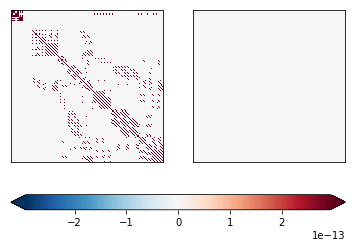

In [5]:
matplot(M,limfrac=1e-12);

The sftiffness matrix

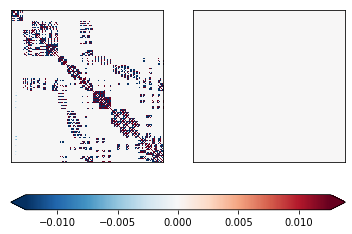

In [6]:
matplot(K,limfrac=1e-12);

The damping matrix is almost zero

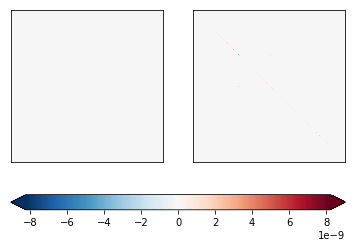

In [7]:
matplot(C,limfrac=1);

### Determining the system structure

The acoustic DoFs are marked in step 1.
Read it and extraxt the indices

In [8]:
rhs1 = np.loadtxt("coupled_step_1_rhs.vec")
r1 = rhs1[:,0] + 1j*rhs1[:,1]
Ia = np.argwhere(np.abs(r1)>1e-12).ravel()
Ia

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

The mechanic DoFs are marked in step 2.
Read the rhight hand sinde load vector and also determine it's pahse to infer x, y, and z DoF.
One can see that CFS assembles alternatingly dor each node (x, then y, then z).

In [9]:
# mech is active in step 2, we use the phase to distinguish components
rhs2 = np.loadtxt("coupled_step_2_rhs.vec")
r2 = rhs2[:,0] + 1j*rhs2[:,1]
Im = np.argwhere(np.abs(r2)>1e-12).ravel()
Ix = np.argwhere(np.abs(np.angle(r2)*180/np.pi - 10)<1e-3).ravel()
Iy = np.argwhere(np.abs(np.angle(r2)*180/np.pi - 20)<1e-3).ravel()
Iz = np.argwhere(np.abs(np.angle(r2)*180/np.pi - 30)<1e-3).ravel()
Ix,Iy,Iz,Im

(array([ 42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
         81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
        120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
        159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
        198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
        237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
        276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309]),
 array([ 43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,  79,
         82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115, 118,
        121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154, 157,
        160, 163, 166, 169, 172, 175, 178, 181, 184, 187, 190, 193, 196,
        199, 202, 205, 208, 211, 214, 217, 220, 223, 226, 229, 232, 235,
        238, 241, 244, 247, 250, 253, 256, 259, 262, 265, 268, 271, 274,
        277, 280, 283, 286, 289, 292, 295, 298, 301, 3

In step 3 the electrostatic nodes get non-zero right hand side loads

In [10]:
rhs3 = np.loadtxt("coupled_step_3_rhs.vec")
r3 = rhs3[:,0] + 1j*rhs3[:,1]
Ip = np.argwhere(np.abs(r3)>1e-12).ravel()
Ip

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41])

Finally we look at the right hand side load vector from step 4 to get the interafce and electode indices

In [11]:
rhs4 = np.loadtxt("coupled_step_4_rhs.vec")
r4 = rhs4[:,0] + 1j*rhs4[:,1]

# the electrode
I = np.argwhere(np.abs(r4[Ip])>1e-1).ravel()
Ipe = Ip[I]

# the acou-iterface nodes
I = np.argwhere(np.abs(r4[Ia])>1e-6).ravel()
Iai = Ia[I]

# the mech interface dofs
I = np.argwhere(np.abs(r4[Im])>1e-6).ravel()
Imi = Im[I]

Now we're rady to polt the system matrix and mark the DoFs in it

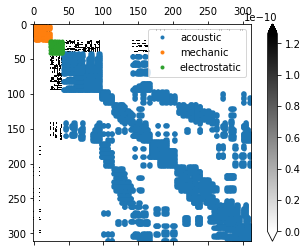

In [12]:
lim = np.max(np.abs(S1))/1e+20
fig,ax = plt.subplots()
cax = ax.matshow(np.abs(S1.real),cmap=plt.cm.gray_r,vmin=0,vmax=lim)
fig.colorbar(cax,extend='both')
ax.plot(*Im[np.argwhere(np.abs(S1[np.ix_(Im,Im)].real)>1e-12)].T,'.',label='acoustic')
ax.plot(*Ia[np.argwhere(np.abs(S1[np.ix_(Ia,Ia)].real)>1e-12)].T,'.',label='mechanic')
ax.plot(*Ip[np.argwhere(np.abs(S1[np.ix_(Ip,Ip)].real)>1e-12)].T,'.',label='electrostatic')
ax.legend()

Similarly, we can plot a vector of degrees of freedom marking the different regions

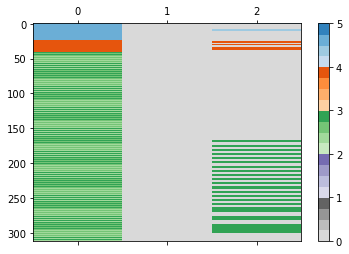

In [13]:
D = np.zeros([S1.shape[0],3])

# in column 1
D[Ia,0] = 4.6 # acoustics in blue
D[Ip,0] = 3.8 # electrostatics in orange
D[Ix,0] = 2.8 # mechanics in green
D[Iy,0] = 2.6 # bit lighter for y
D[Iz,0] = 2.4 # and z

# in column 3
D[Iai,2] = 4.4 # interface (acou)
D[Ipe,2] = 3.8 # piezo electrode
D[Imi,2] = 2.8 # interface (mech)

fig,ax = plt.subplots()
cax = ax.matshow(D,cmap=plt.cm.tab20c_r,vmin=0,vmax=5)
fig.colorbar(cax)
ax.set_aspect('auto')

We can also extract certain sub-matrix-blocks and plot them

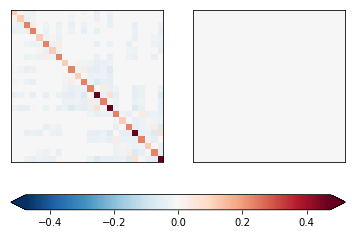

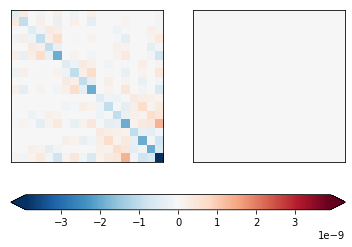

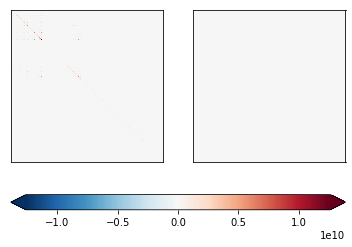

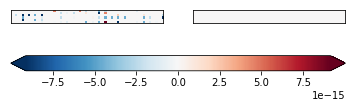

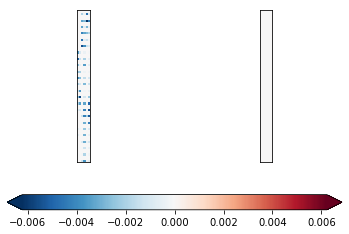

In [15]:
for A in [ K[np.ix_(Ia,Ia)], K[np.ix_(Ip,Ip)], K[np.ix_(Im,Im)],K[np.ix_(Iai,Imi)],K[np.ix_(Imi,Iai)]  ]:
    matplot(A)